# Lab 12: Transformers, Speech Recognition

In this lab, we'll go through two tutorials, one on the Transformer architecture and one
on end-to-end training of a (recurrent) speech recognition system.

The open question will be whether we can adapt the Transformer to the speech recognition task.


## Transformer With Torchtext

First, let's see how to train a sequence-to-sequence model that uses the `nn.Transformer` module
and the torchtext module in PyTorch.

This is from [the Pytorch Transformer tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html).

The Transformer as we know has obtained superior results in many sequence to sequence problems. PyTorch's
nn.Transformer module implements the Transformer, especially the attention mechanism
(implemented in `nn.MultiheadAttention`) to model the global dependencies between elements of the input sequence,
elements of the output sequence, and input-output dependencies.
The `nn.Transformer` module is highly modularized, so we can use a single component
(`nn.TransformerEncoder` in this tutorial) can be easily adapted/composed.

<img src="img/transformer.png" title="transformer" style="width: 400px;" />

### Language modeling task

Our goal will be to assign a probability for the likelihood of a given word (or a sequence of words) following a sequence of words.
A sequence of tokens is passed to an embedding layer first, followed by a positional encoding layer that accounts for the ordering of the words.

### The model

The TransformerEncoder consists of multiple layers of
TransformerEncoderLayer. Along with the input sequence, we'll use an attention mask so that the self-attention layers in the
TransformerEncoder are only allowed to attend the earlier positions in the sequence
(in this language modeling task, tokens in the future positions should be masked).
To form output words, the output of the TransformerEncoder model is sent to a final Linear layer, which is followed by a log-Softmax function.

### PositionalEncoding module

The PositionalEncoding module injects information about
relative or absolute positions of the tokens in the sequence. Positional encodings have the same dimension
as embeddings, so that the two can be summed. Here, as in the original Transformer paper,

we use sine and cosine functions of different frequencies.

In [1]:
import comet_ml
from comet_ml import Experiment
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

### Load data

This lab uses the Wikitext-2 dataset via the `torchtext` module.
The vocabulary object is built based on the training dataset and is used to embed tokens into tensors.
Starting from sequential data, the `batchify()` function arranges the dataset into columns, trimming off
any tokens remaining after the data has been divided into batches of size batch_size. For instance, with the alphabet
as the sequence (total length of 26) and a batch size of 4, we can divide the alphabet into 4 sequences of length 6:

\begin{split}\begin{bmatrix}
\text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
\end{bmatrix}
\Rightarrow
\begin{bmatrix}
\begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
\begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
\begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
\begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
\end{bmatrix}\end{split}

These columns are treated as independent by the model, which means that the dependence of G and F can not be learned, but allows more efficient batch processing.

In [2]:
import io
import torch
from torchtext.datasets import WikiText103, WikiText2
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for line in train_iter:
    counter.update(tokenizer(line))
vocab = Vocab(counter)



I use validation set of WikiText103 as my test set.

In [3]:
def data_process(raw_text_iter):
  data = [torch.tensor([vocab[token] for token in tokenizer(item)],
                       dtype=torch.long) for item in raw_text_iter]
  return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

val_iter = WikiText103(split='valid')
val_data = data_process(val_iter)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
val_data = batchify(val_data, eval_batch_size)

### Generate input and target sequences

Here is the idea of input and target sequences. As always with
time sequences in PyTorch, the tensor dimensions are (time x batch element):

<img src="img/transformer_input_target1.png" title="input-target" style="width: 400px;" />

In [4]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

### Initialize the model

Next let's initialize the model:

In [5]:
ntokens = len(vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)
# load model
model.load_state_dict(torch.load('./models/TransformerModel_3.weight'))
model.eval()

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=200, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=200, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=20

### Run the model

Now let's train it. Note that in the language modeling
community, exp(negative log likelihood) is called "Perplexity"
and abbreviated PPL.

In [6]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

In [7]:
# best_val_loss = float("inf")
# epochs = 3 # The number of epochs
# best_model = None

# for epoch in range(1, epochs + 1):
#     epoch_start_time = time.time()
#     train()
#     val_loss = evaluate(model, val_data)
#     print('-' * 89)
#     print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
#           'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
#                                      val_loss, math.exp(val_loss)))
#     print('-' * 89)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_model = model

#     scheduler.step()

### Evaluate the model with test data

In [8]:
test_loss = evaluate(model, val_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  5.65 | test ppl   283.99


## End-to-end (Recurrent) Speech Recognition Model

Now let's look at an example of how to do sound processing
in PyTorch using the torchaudio module.

This tutorial is from [Assembly AI's blog on end-to-end speech recognition](https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch).

Other references:
- https://colab.research.google.com/drive/1IPpwx4rX32rqHKpLz7dc8sOKspUa-YKO#scrollTo=RVJs4Bk8FjjO
- https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html (base code)

The model we'll build is inspired by Deep Speech 2 from Baidu with some improvements by Assembly AI.
The output of the model is a probability matrix of characters, which will be decoded to the most likely sequence of characters spoken in the audio.

### Prepare dataset

Data is one of the most important aspects of speech recognition. We'll take raw audio waves and transform them into Mel Spectrograms.

<img src="img/transformer_spectrograms.png" title="Mel Spectrograms" style="width: 480px;" />

For handling the audio data, we are going to use an extremely useful utility called torchaudio which is a library built by the PyTorch team specifically for audio data. We'll be training on a subset of LibriSpeech (http://www.openslr.org/12/), which is a corpus of read English speech data derived from audiobooks, comprising 100 hours of transcribed audio data. You can easily download this dataset using torchaudio:

In [9]:
import os
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [10]:
test_dataset = torchaudio.datasets.SPEECHCOMMANDS("./data", url="speech_commands_v0.02", download=True, subset='testing')

Sample dataset

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


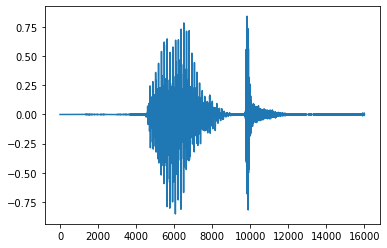

In [11]:
waveform, sample_rate, utterance, speaker_id, utterance_id = test_dataset[0]

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

ipd.Audio(waveform.numpy(), rate=sample_rate)

## Data Augmentation - SpecAugment

Data augmentation is a technique used to artificially increase the diversity of your dataset in order to increase your dataset size. This strategy is especially helpful when data is scarce or if your model is overfitting. For speech recognition, you can do the standard augmentation techniques, like changing the pitch, speed, injecting noise, and adding reverb to your audio data.

We found Spectrogram Augmentation (SpecAugment), to be a much simpler and more effective approach. SpecAugment, was first introduced in the paper SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition (https://arxiv.org/abs/1904.08779), in which the authors found that simply cutting out random blocks of consecutive time and frequency dimensions improved the models generalization abilities significantly!

<img src="img/transformer_freq.png" title="frequency" style="width: 480px;" />

In PyTorch, you can use the torchaudio function FrequencyMasking to mask out the frequency dimension, and TimeMasking for the time dimension.

In [12]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

/usr/local/lib/python3.6/dist-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Now that we have the data, we'll need to transform the audio into Mel Spectrograms, and map the character labels for each audio sample into integer labels:

In [13]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')

In [14]:
valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = TextTransform()

In [15]:
def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

## Define the Model - Deep Speech 2

The model will be similar to the Deep Speech 2 architecture. The model will have two main neural network modules - N layers of Residual Convolutional Neural Networks (ResCNN) to learn the relevant audio features, and a set of Bidirectional Recurrent Neural Networks (BiRNN) to leverage the learned ResCNN audio features. The model is topped off with a fully connected layer used to classify characters per time step.

<img src="img/transformer_deepspeech2.png" title="deepspeech2" style="width: 800px;" />

Convolutional Neural Networks (CNN) are great at extracting abstract features, and we'll apply the same feature extraction power to audio spectrograms. Instead of just vanilla CNN layers, we choose to use Residual CNN layers. Residual connections (AKA skip connections) were first introduced in the paper Deep Residual Learning for Image Recognition, where the author found that you can build really deep networks with good accuracy gains if you add these connections to your CNN's. Adding these Residual connections also helps the model learn faster and generalize better. The paper Visualizing the Loss Landscape of Neural Nets shows that networks with residual connections have a “flatter” loss surface, making it easier for models to navigate the loss landscape and find a lower and more generalizable minima.

<img src="img/transformer_skipconncompare.png" title="" style="width: 400px;" />

Recurrent Neural Networks (RNN) are naturally great at sequence modeling problems. RNN's processes the audio features step by step, making a prediction for each frame while using context from previous frames. We use BiRNN's because we want the context of not only the frame before each step, but the frames after it as well. This can help the model make better predictions, as each frame in the audio will have more information before making a prediction. We use Gated Recurrent Unit (GRU's) variant of RNN's as it needs less computational resources than LSTM's, and works just as well in some cases.

The model outputs a probability matrix for characters which we'll use to feed into our decoder to extract what the model believes are the highest probability characters that were spoken.

In [16]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

### Evaluation metrics

Here are implementations of the common evaluation metrics for speech recognition:

In [17]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

## Monitoring experiments using comet.ml

Comet.ml provides a platform that allows deep learning researchers to track, compare, explain, and optimize their experiments and models. Comet.ml has improved our productivity at AssemblyAI and we highly recommend using this platform for teams doing any sort of data science experiments. Comet.ml is super easy to set up. And works with just a few lines of code.

<img src="img/transformer_comet_ml.png" title="comet_ml" style="width: 800px;" />

In [18]:
# To use comet.ml, which is kind of cool but requires an account and API key from them,
# go to comet.ml, create an account, create project, and create an API key. Then fill
# in the variables

# Create an experiment with your api key
experiment = Experiment(
    api_key="9neHTMUQ1vfL6kScdIX9UTg4n",
    project_name="rtml-class",
    workspace="kagakuosakura",
)
# Later, you can track metrics in the cloud GUI. To log a loss:

# experiment.log_metric('loss', loss.item())

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kagakuosakura/rtml-class/e9ffac64f84a4ca3adba434eee0bf792



## Training function

In [19]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, experiment):
    model.train()
    data_len = len(train_loader.dataset)
    with experiment.train():
        for batch_idx, _data in enumerate(train_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            optimizer.zero_grad()

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            loss.backward()

            experiment.log_metric('loss', loss.item(), step=iter_meter.get())
            experiment.log_metric('learning_rate', scheduler.get_lr(), step=iter_meter.get())

            optimizer.step()
            scheduler.step()
            iter_meter.step()
            if batch_idx % 100 == 0 or batch_idx == data_len:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(spectrograms), data_len,
                    100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, criterion, epoch, iter_meter, experiment):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with experiment.test():
        with torch.no_grad():
            for i, _data in enumerate(test_loader):
                spectrograms, labels, input_lengths, label_lengths = _data 
                spectrograms, labels = spectrograms.to(device), labels.to(device)

                output = model(spectrograms)  # (batch, time, n_class)
                output = F.log_softmax(output, dim=2)
                output = output.transpose(0, 1) # (time, batch, n_class)

                loss = criterion(output, labels, input_lengths, label_lengths)
                test_loss += loss.item() / len(test_loader)

                decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
                for j in range(len(decoded_preds)):
                    test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                    test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    experiment.log_metric('test_loss', test_loss, step=iter_meter.get())
    experiment.log_metric('cer', avg_cer, step=iter_meter.get())
    experiment.log_metric('wer', avg_wer, step=iter_meter.get())

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))

## Picking the Right Optimizer and Scheduler - AdamW with Super Convergence

AdamW was first introduced in Decoupled Weight Decay Regularization (https://arxiv.org/abs/1711.05101), and is considered a “fix” to Adam. The paper pointed out that the original Adam algorithm has a wrong implementation of weight decay, which AdamW attempts to fix. This fix helps with Adam's generalization problem.

<img src="img/transformer_adamw.jpeg" title="AdamW" style="width: 400px;" />

## The CTC Loss Function - Aligning Audio to Transcript

The innovation of the CTC loss function is that it allows us to skip this step. Our model will learn to align the transcript itself during training. The key to this is the “blank” label introduced by CTC, which gives the model the ability to say that a certain audio frame did not produce a character.

<img src="img/transformer_ctcloss.png" title="ctc loss" style="width: 400px;" />

In [20]:
learning_rate=5e-4
batch_size=20
epochs=10

# experiment=Experiment(api_key='dummy_key', disabled=True)

hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

# experiment.log_parameters(hparams)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
# train_loader = data.DataLoader(dataset=train_dataset,
#                             batch_size=hparams['batch_size'],
#                             shuffle=True,
#                             collate_fn=lambda x: data_processing(x, 'train'),
#                             **kwargs)
test_loader = data.DataLoader(dataset=test_dataset,
                            batch_size=hparams['batch_size'],
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x, 'valid'),
                            **kwargs)

model = SpeechRecognitionModel(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
    ).to(device)

print(model)
print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=28).to(device)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                        steps_per_epoch=int(len(train_loader)),
                                        epochs=hparams['epochs'],
                                        anneal_strategy='linear')

SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

NameError: name 'train_loader' is not defined

## Evaluating Your Speech Model
When Evaluating your speech recognition model, the industry standard is using the Word Error Rate (WER) as the metric. The Word Error Rate does exactly what it says - it takes the transcription your model outputs, and the true transcription, and measures the error between them. You can see how that's implemented here. Another useful metric is called the Character Error Rate (CER). The CER measures the error of the characters between the model's output and the true labels. These metrics are helpful to measure how well your model performs.

For this tutorial, we'll use a "greedy" decoding method to process our model's output into characters that can be combined to create the transcript. A "greedy" decoder takes in the model output, which is a softmax probability matrix of characters, and for each time step (spectrogram frame), it chooses the label with the highest probability. If the label is a blank label, we remove it from the final transcript.

In [43]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

## Start training and evaluating on the test set

In [44]:
iter_meter = IterMeter()
# for epoch in range(1, epochs + 1):
#     train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, experiment)
#     print('saving...')
#     torch.save(model.state_dict(), f'./model/SpeechRecognitionModel_{epoch}.weight')
#     print('save complete')
#     test(model, device, test_loader, criterion, epoch, iter_meter, experiment)


In [45]:
model.load_state_dict(torch.load('./models/SpeechRecognitionModel_2.weight'))
test(model, device, test_loader, criterion, 0, iter_meter, experiment)


evaluating...
Test set: Average loss: 2.6771, Average CER: 0.645727 Average WER: 1.1629



## In-lab exercises

1. Spend some time to understand the Transformer and Speech Recognition examples.
2. After training, test the two models on some data (text, audio) you provide yourself

## Homework

Since you're all extremely busy with your projects (RIGHT??), for the homework for this week,
write an explanation of the steps that would be needed to adapt the PyTorch transformer to
the speech recognition task. Be specific in how you would do the implementation, but you do
not need to ac

## Implement transformer to speech recognition model

We can add transformer layer before BiRNN layer of speech recognition model. This will encourage impotant audio features which come from ResCNN.